<a href="https://colab.research.google.com/github/ShahedSabab/movie-recommender/blob/main/Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!nvidia-smi

Sat Nov 21 00:21:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from matplotlib import rc
from pylab import rcParams
import itertools
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from collections import Counter
from statistics import mean 
from collections import defaultdict
from sklearn.metrics import silhouette_samples, silhouette_score

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Read Data

In [26]:
# read the movies data
df_movies = pd.read_csv('movies.csv')

In [27]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [28]:
# read the rating data
df_ratings = pd.read_csv('ratings.csv')

In [29]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


# EDA

### Popular Movies by average rating

In [30]:
rating = df_ratings.groupby('movieId').rating.mean().to_dict()

In [31]:
df_movies_ext = df_movies

In [32]:
avg_rating_col = []
for index, row in df_movies_ext.iterrows():
  val = row['movieId']
  if val in rating.keys():
    avg_rating_col.append(rating[val])
  else:
    avg_rating_col.append(np.nan)

df_movies_ext['avg_rating'] = avg_rating_col

In [33]:
df_movies_ext.sort_values('avg_rating', ascending=False).head(20)

,movieId,title,genres,avg_rating
7656,88448,Paper Birds (Pájaros de papel) (2010),Comedy|Drama,5.0
8107,100556,"Act of Killing, The (2012)",Documentary,5.0
9083,143031,Jump In! (2007),Comedy|Drama|Romance,5.0
9094,143511,Human (2015),Documentary,5.0
9096,143559,L.A. Slasher (2015),Comedy|Crime|Fantasy,5.0
4251,6201,Lady Jane (1986),Drama|Romance,5.0
8154,102217,Bill Hicks: Revelations (1993),Comedy,5.0
8148,102084,Justice League: Doom (2012),Action|Animation|Fantasy,5.0
4246,6192,Open Hearts (Elsker dig for evigt) (2002),Romance,5.0
9122,145994,Formula of Love (1984),Comedy,5.0


### Popular genre by average rating

In [34]:
# make a dictionary having all the avg_ratings of users 
limit = len(df_movies_ext)
genre_dict = defaultdict(list)
for index, row in itertools.islice(df_movies_ext.iterrows(), limit):
  val = row['genres'].split('|')
  for v in val:
    genre_dict[v].append(row['avg_rating'])

In [35]:
# Calculate the average ratings per genre
genre_dict_avg = {}
genre_dict_count = {}
for key in genre_dict:
  genre_dict_avg[key] = np.nanmean(genre_dict[key])
  genre_dict_count[key] = np.count_nonzero(~np.isnan(genre_dict[key]))

In [36]:
# top N category
N = 15
topCat = dict(Counter(genre_dict_avg).most_common(N))

In [37]:
df_cat = pd.DataFrame([topCat])

Text(0.5, 1.0, 'Popular genre by ratings')

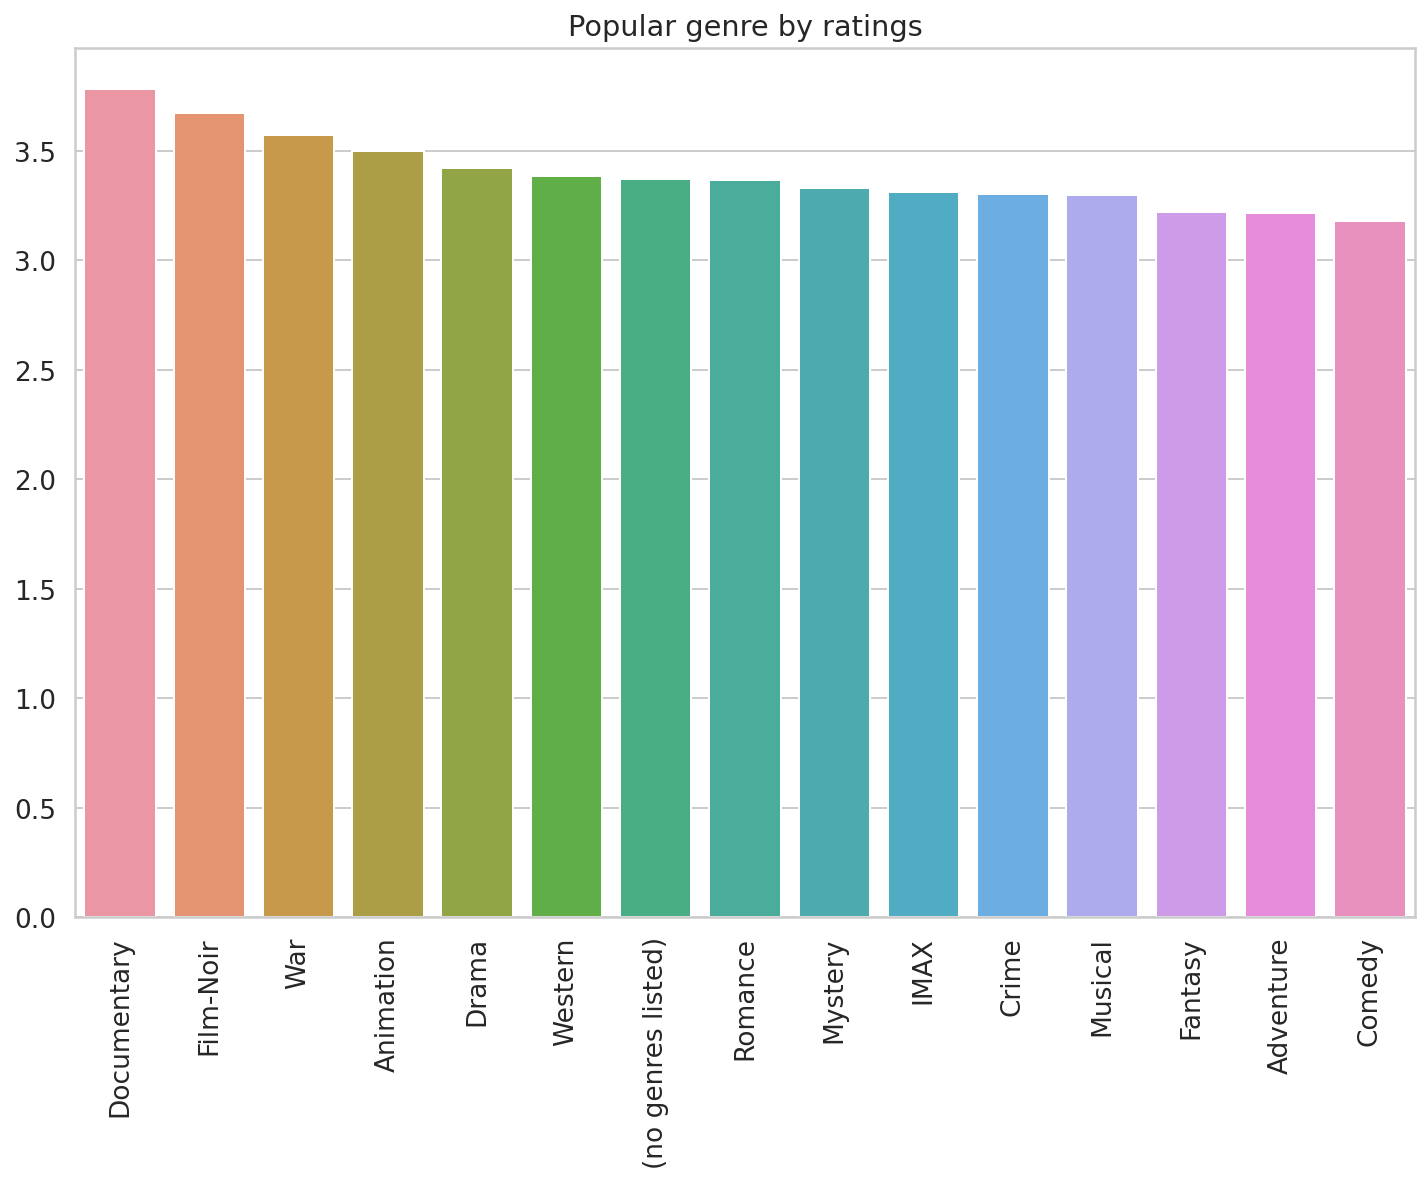

In [38]:
sns.barplot(data=df_cat)
plt.xticks(rotation=90)
plt.title('Popular genre by ratings')

Seems like documetary is the highest rated genre

### Number of users rated a genre

In [39]:
# top N category
N = 15
topCat = dict(Counter(genre_dict_count).most_common(N))
df_count = pd.DataFrame([topCat])

Text(0.5, 1.0, '# of users rated a genre')

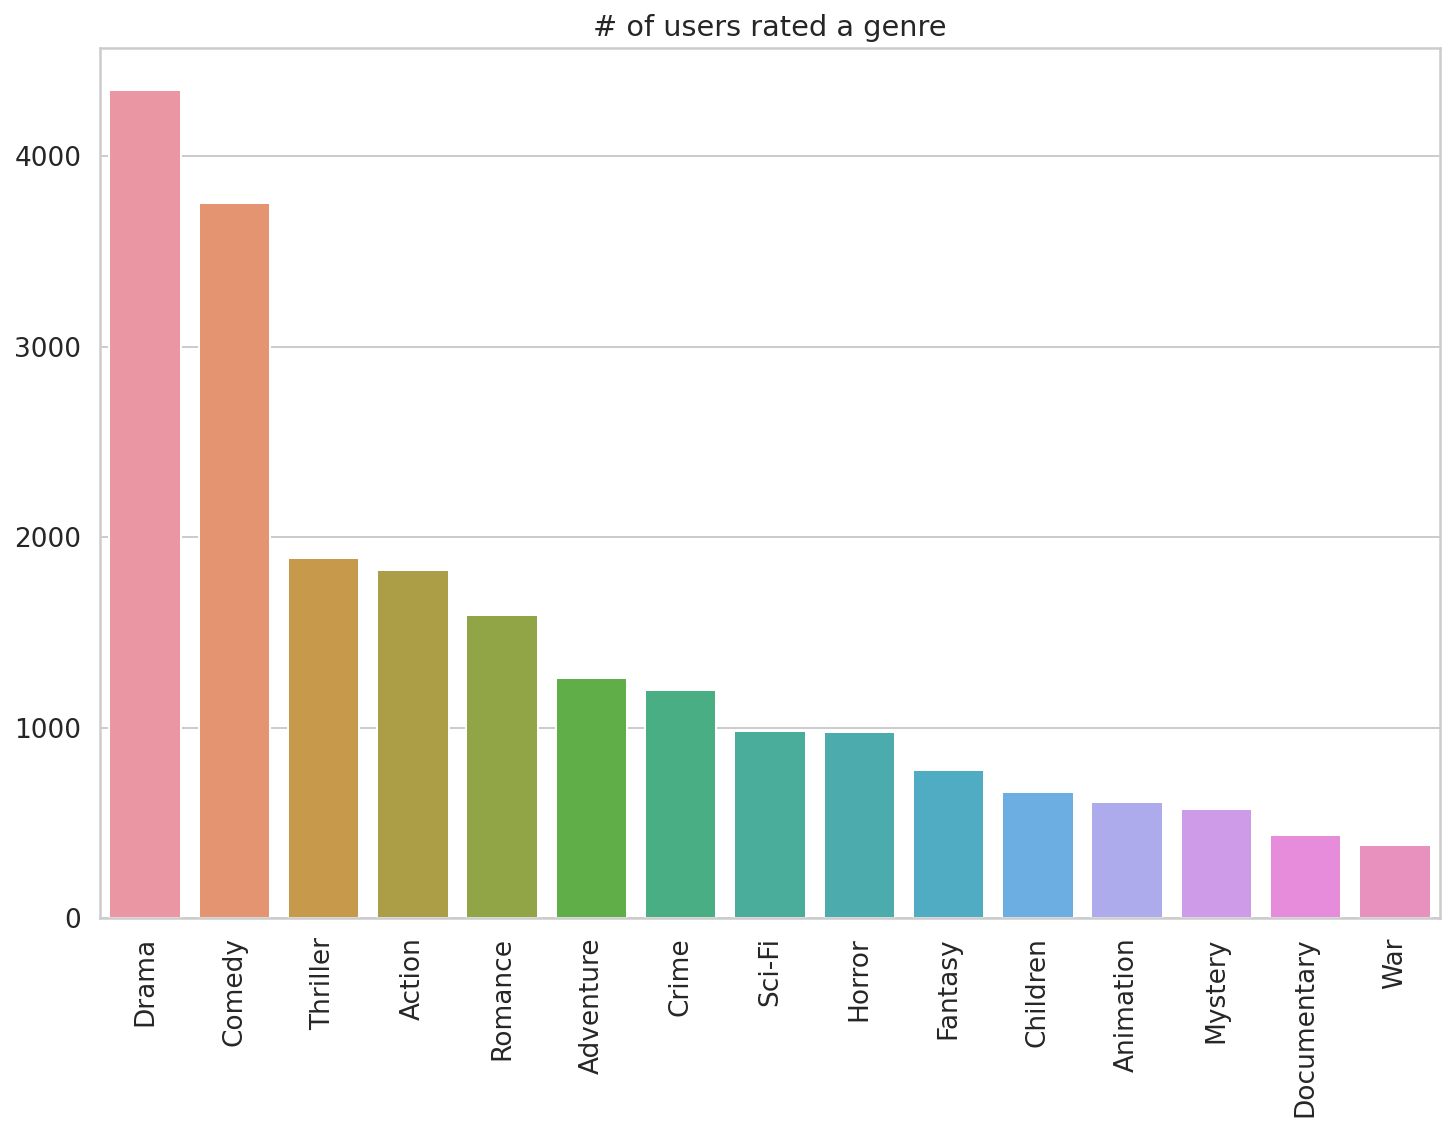

In [40]:
sns.barplot(data=df_count)
plt.xticks(rotation=90)
plt.title('# of users rated a genre')

Seems like there are more users rated the drama and comedy genre. Let's take a close look at these two genre.

# Higher-level clustering

In [48]:
# Reshaping the data to have user id as the index and movie ratings as the features
df_ratings_ext = pd.merge(df_ratings, df_movies[['movieId', 'title']], on = 'movieId')
df_movie_ratings_user = pd.pivot_table(df_ratings_ext, index = 'userId', columns='title', values='rating')

In [49]:
df_movie_ratings_user[:20]

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Most of the fields are NaNs thats because every user rated only a few movies but this table represents all the movies in the dataset. 

### Visualize a subset of the data


In [64]:
# choose the number of movies and users and sort
n_movies = 30
n_users = 20
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define the sorting by rating function
def sort_rating(df_movie_ratings_user, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(df_movie_ratings_user, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

most_rated_movies_users_selection = sort_rating(df_movie_ratings_user, n_movies, n_users)
# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()


dataset dimensions:  (20, 30)


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)"
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,3.5,4.0,5.0,4.5,3.0,3.0,4.0,4.5,5.0,4.5,4.5,5.0,4.0,3.5,4.0,5.0,4.5,4.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,4.0,4.0,5.0,4.0,3.5,4.0,4.0,4.5,4.0,5.0,4.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,4.5,3.0,5.0,3.5,4.0,4.5,3.0,3.5,5.0,3.5,3.5,5.0,3.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,2.5,2.5,5.0,3.0,5.0,4.0,4.0,3.0,5.0,4.5,5.0,4.0,4.5,4.0,4.0,4.0,4.5,3.5,2.5,2.5


Here, we only see a subset of the sorted (by movies and # of users) data. This would prevent the sparse data issue.

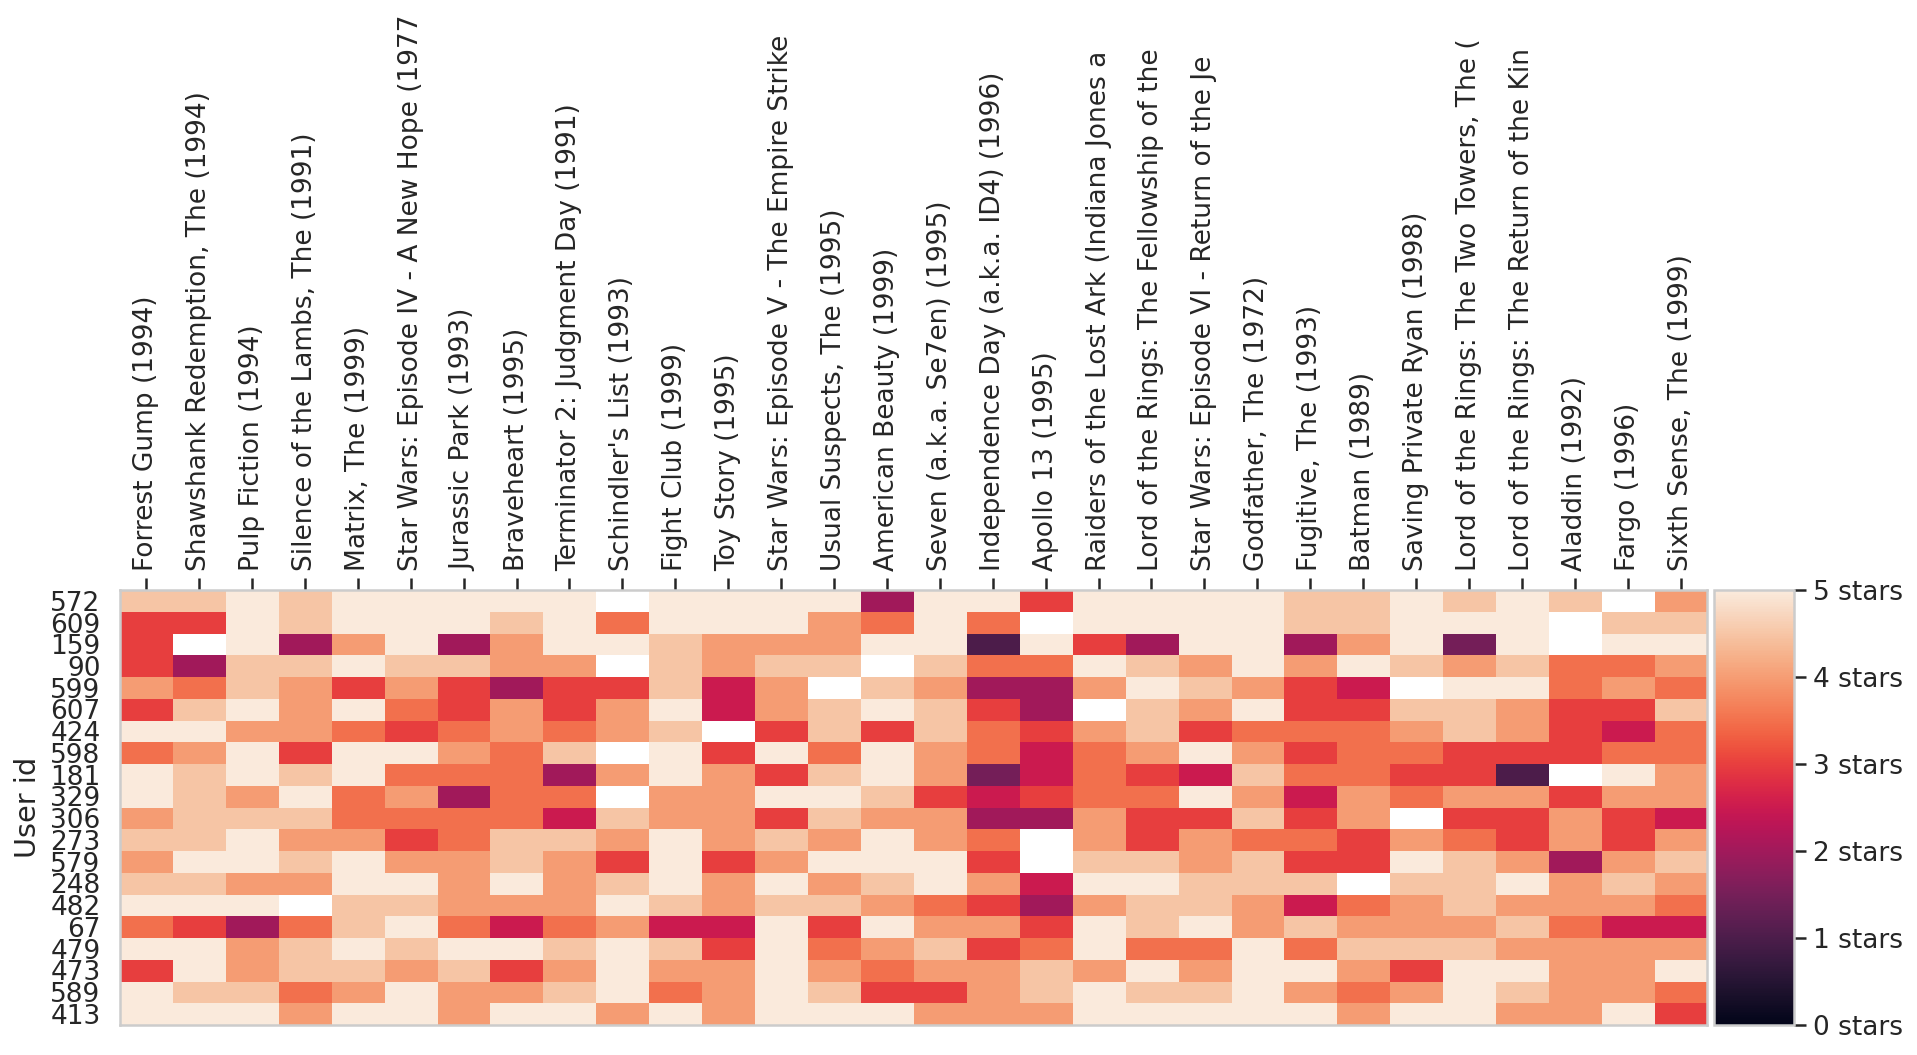

In [65]:
# ref: https://programming.rhysshea.com/K-means_movie_ratings/
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
  fig = plt.figure(figsize=(15,4))
  ax = plt.gca()

  # Draw heatmap
  heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
  if axis_labels:
          ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
          ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
          ax.invert_yaxis()
          ax.xaxis.tick_top()
          labels = most_rated_movies_users_selection.columns.str[:40]
          ax.set_xticklabels(labels, minor=False)
          ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
          plt.setp(ax.get_xticklabels(), rotation=90)
  else:
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    
  ax.grid(False)
  ax.set_ylabel('User id')
  # Separate heatmap from color bar
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  # Color bar
  cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
  cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
  plt.show()

# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

## K-means for 1000 dimensions

In [52]:
# choosing a sub-sample of the data with 1000 movies only
most_rated_movies_1k = get_most_rated_movies(df_movie_ratings_user, 1000)
most_rated_movies_1k

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),"Usual Suspects, The (1995)",American Beauty (1999),Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),Mission: Impossible (1996),...,Gandhi (1982),Cube (1997),Forever Young (1992),Spy Game (2001),Pride & Prejudice (2005),Patch Adams (1998),Rise of the Planet of the Apes (2011),Bedazzled (2000),"Princess Diaries, The (2001)",Avengers: Age of Ultron (2015),All the President's Men (1976),Wallace & Gromit: The Best of Aardman Animation (1996),Scent of a Woman (1992),Star Trek Into Darkness (2013),Ghost in the Shell (Kôkaku kidôtai) (1995),Do the Right Thing (1989),Spawn (1997),Birdman: Or (The Unexpected Virtue of Ignorance) (2014),Arrival (2016),Airheads (1994),"13th Warrior, The (1999)",Private Parts (1997),"Lost Boys, The (1987)","Naked Gun 2 1/2: The Smell of Fear, The (1991)",The Hunger Games: Catching Fire (2013),"Mighty Ducks, The (1992)","Village, The (2004)",Buffy the Vampire Slayer (1992),In & Out (1997),Bad Santa (2003),Scary Movie 2 (2001),About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990)
0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,5.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
4,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,5.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,3.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [53]:
# Conversion to sparse csr matrix and replace the nans as -1
sparse_ratings = csr_matrix(most_rated_movies_1k.fillna(-1).values)


# Choosing the value of K

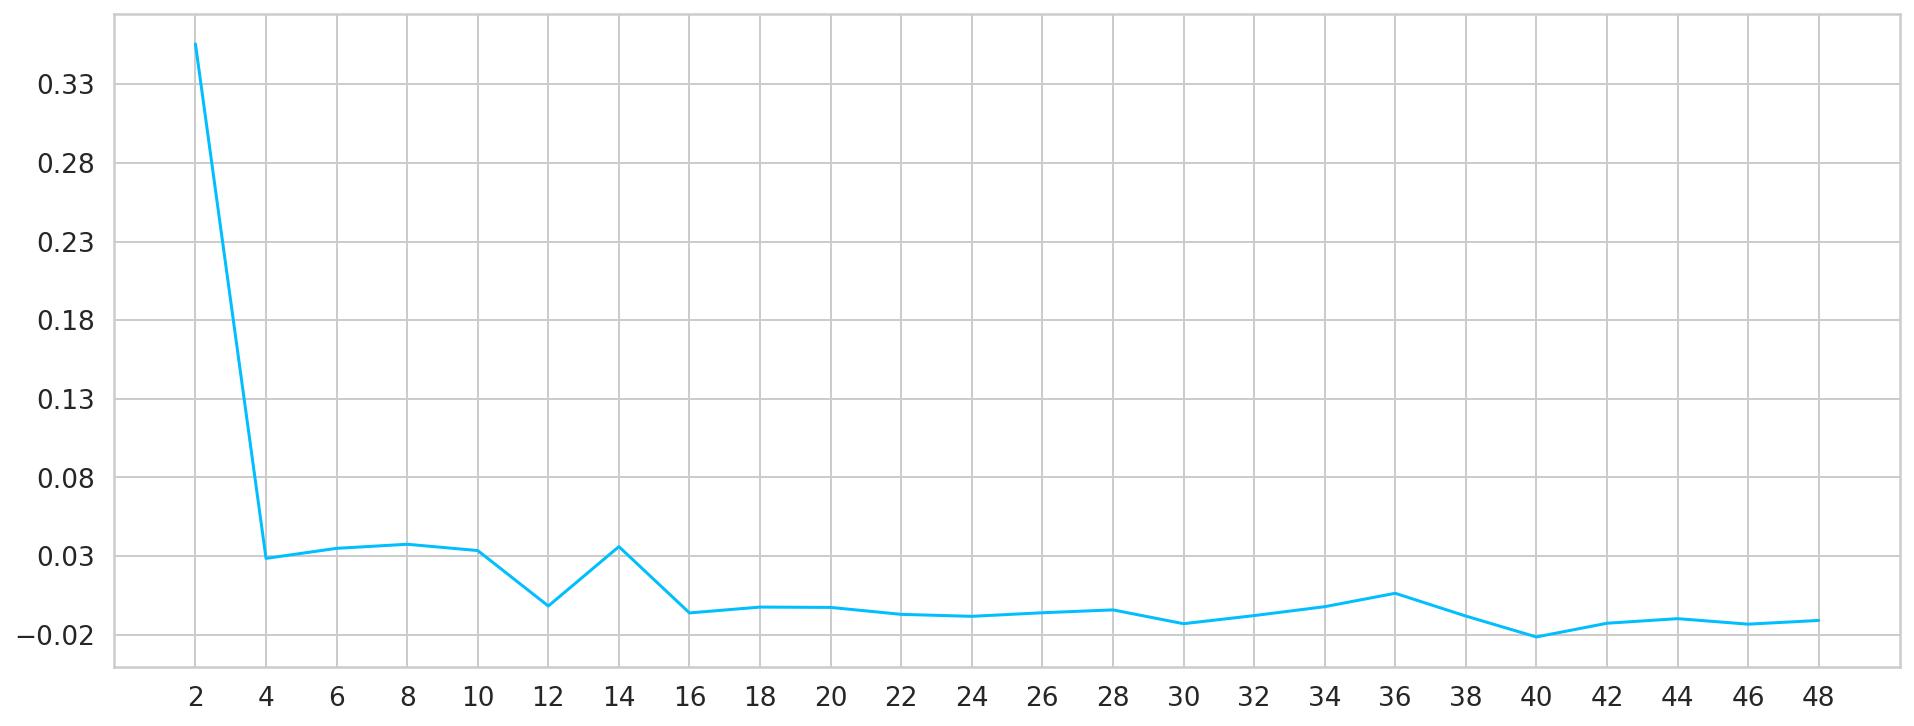

In [54]:
# Ref: https://programming.rhysshea.com/K-means_movie_ratings/
# Selecting our dataset to study
X = sparse_ratings
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, 50, 2)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 2.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

According to the silhouette score k=14 seems to be a separation point for the clusters.

### K means clustering with K = 14

In [55]:
# 20 clusters
predictions = KMeans(n_clusters=14, algorithm='full').fit_predict(sparse_ratings)

In [56]:
# ref: https://programming.rhysshea.com/K-means_movie_ratings/
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_rating(d, max_movies, max_users)
        
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()

### Visualize the clusters of generated by K-Means

cluster # 8
# of users in cluster: 20. # of users in plot: 20


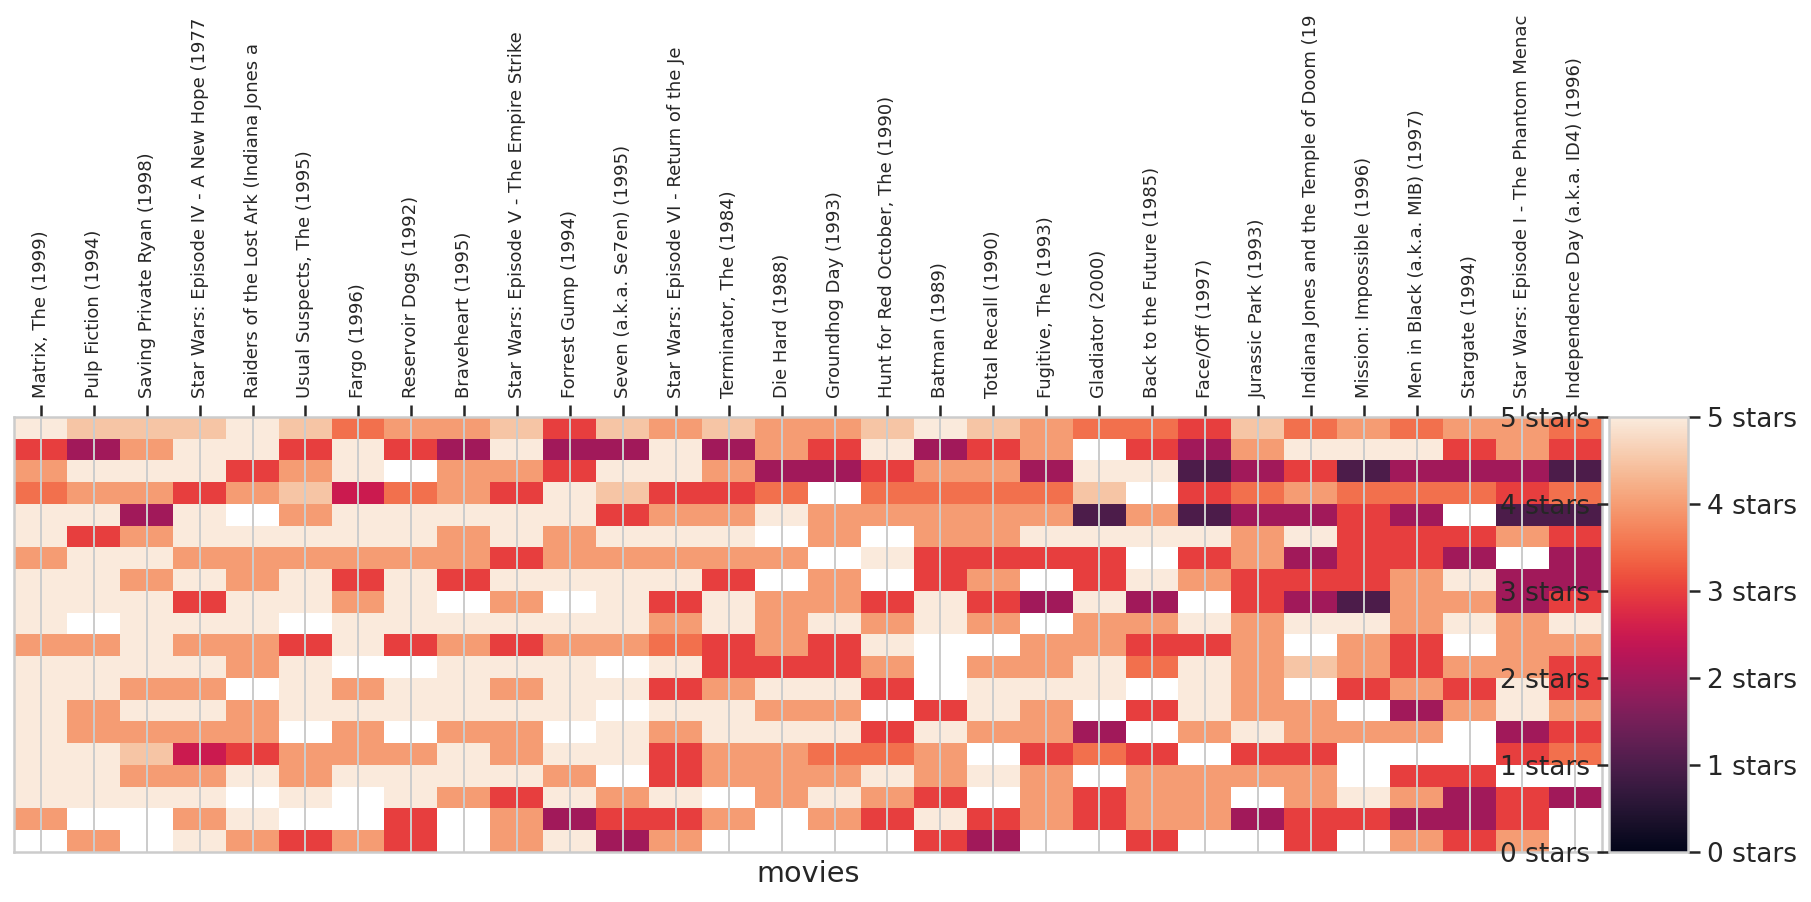

cluster # 7
# of users in cluster: 229. # of users in plot: 20


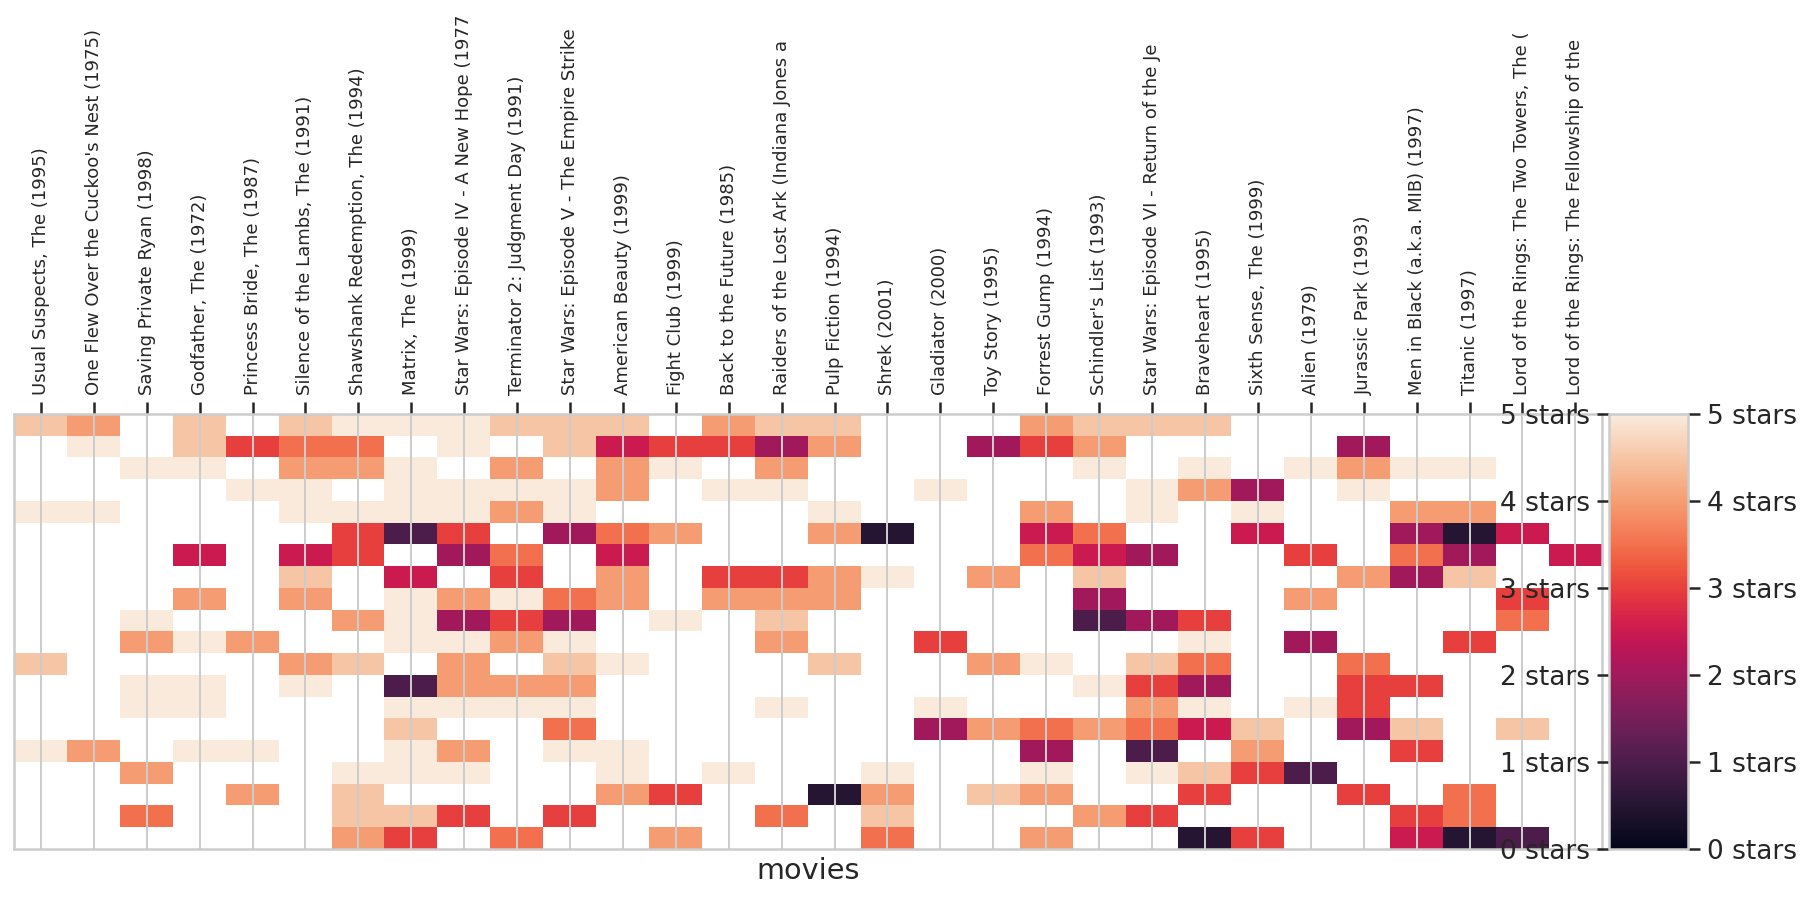

cluster # 5
# of users in cluster: 49. # of users in plot: 20


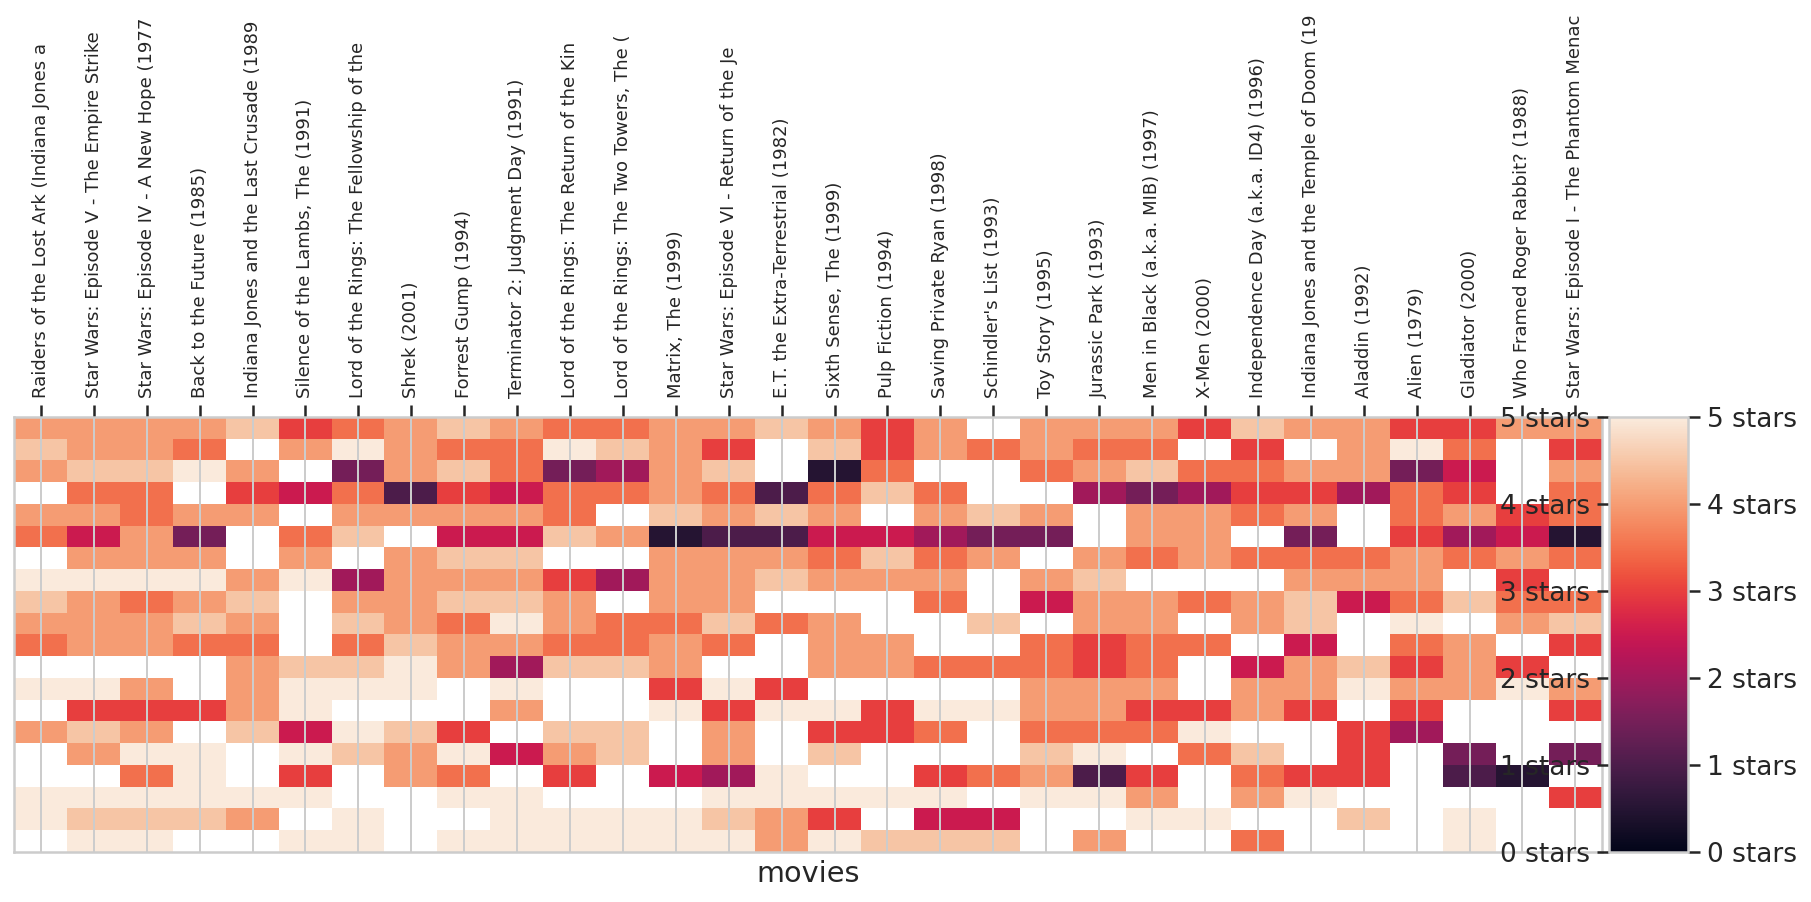

cluster # 6
# of users in cluster: 74. # of users in plot: 20


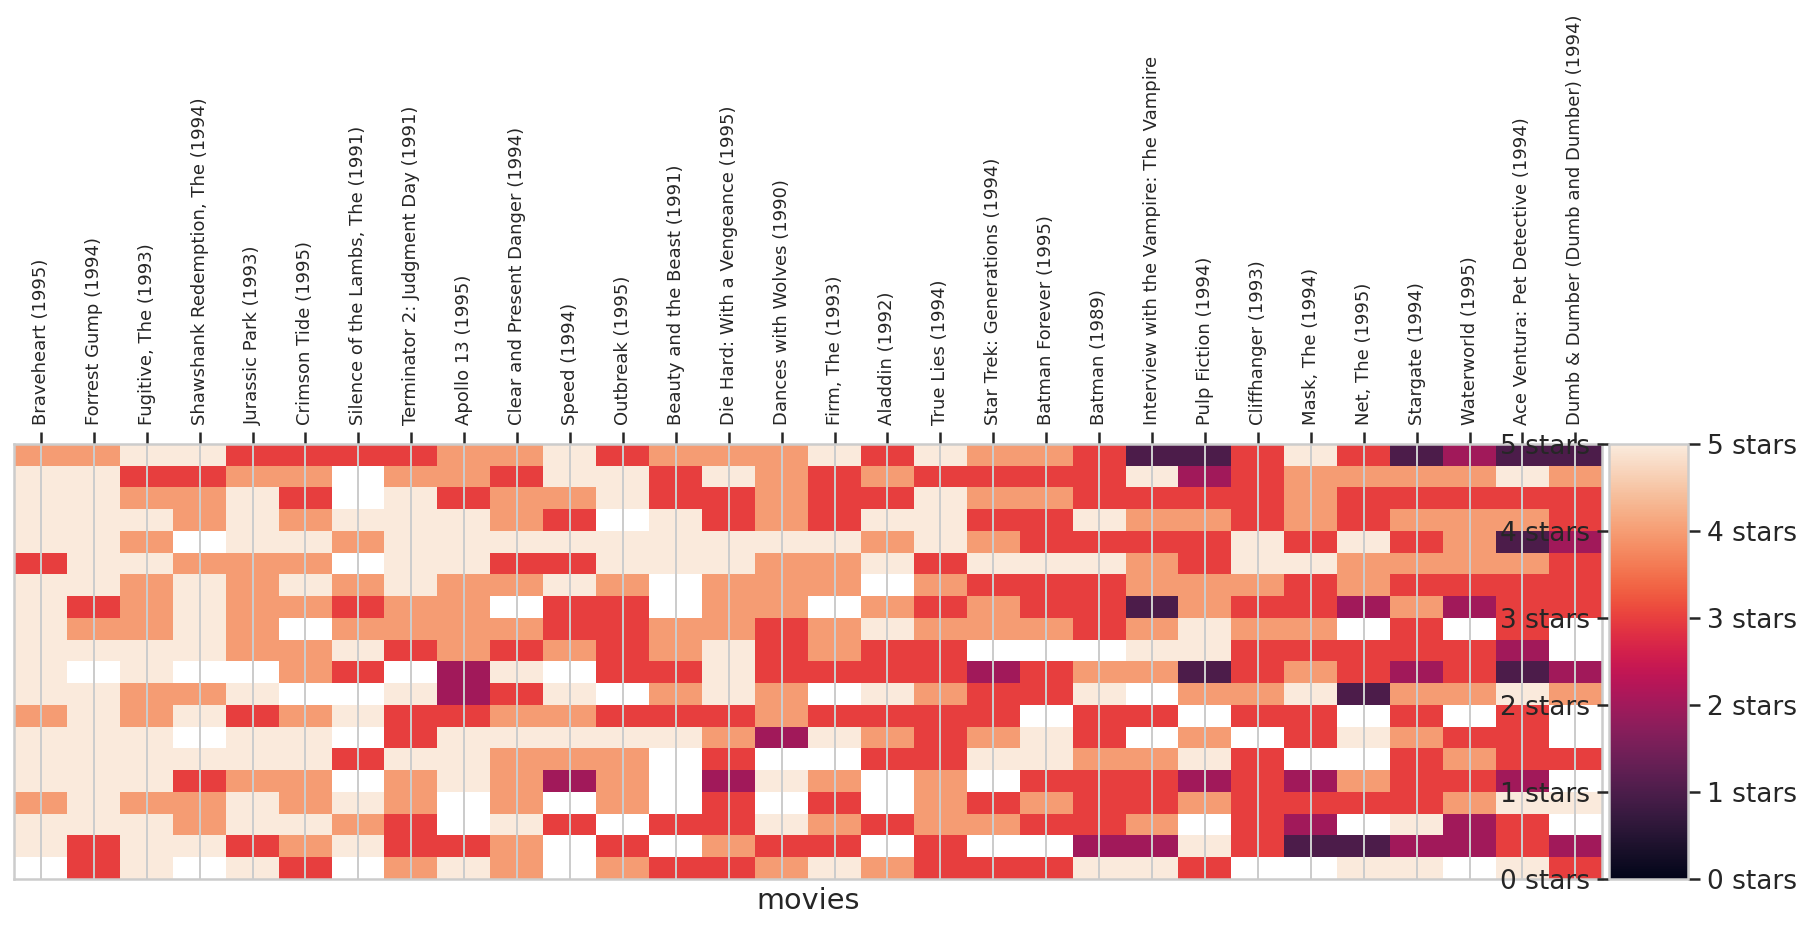

cluster # 10
# of users in cluster: 26. # of users in plot: 20


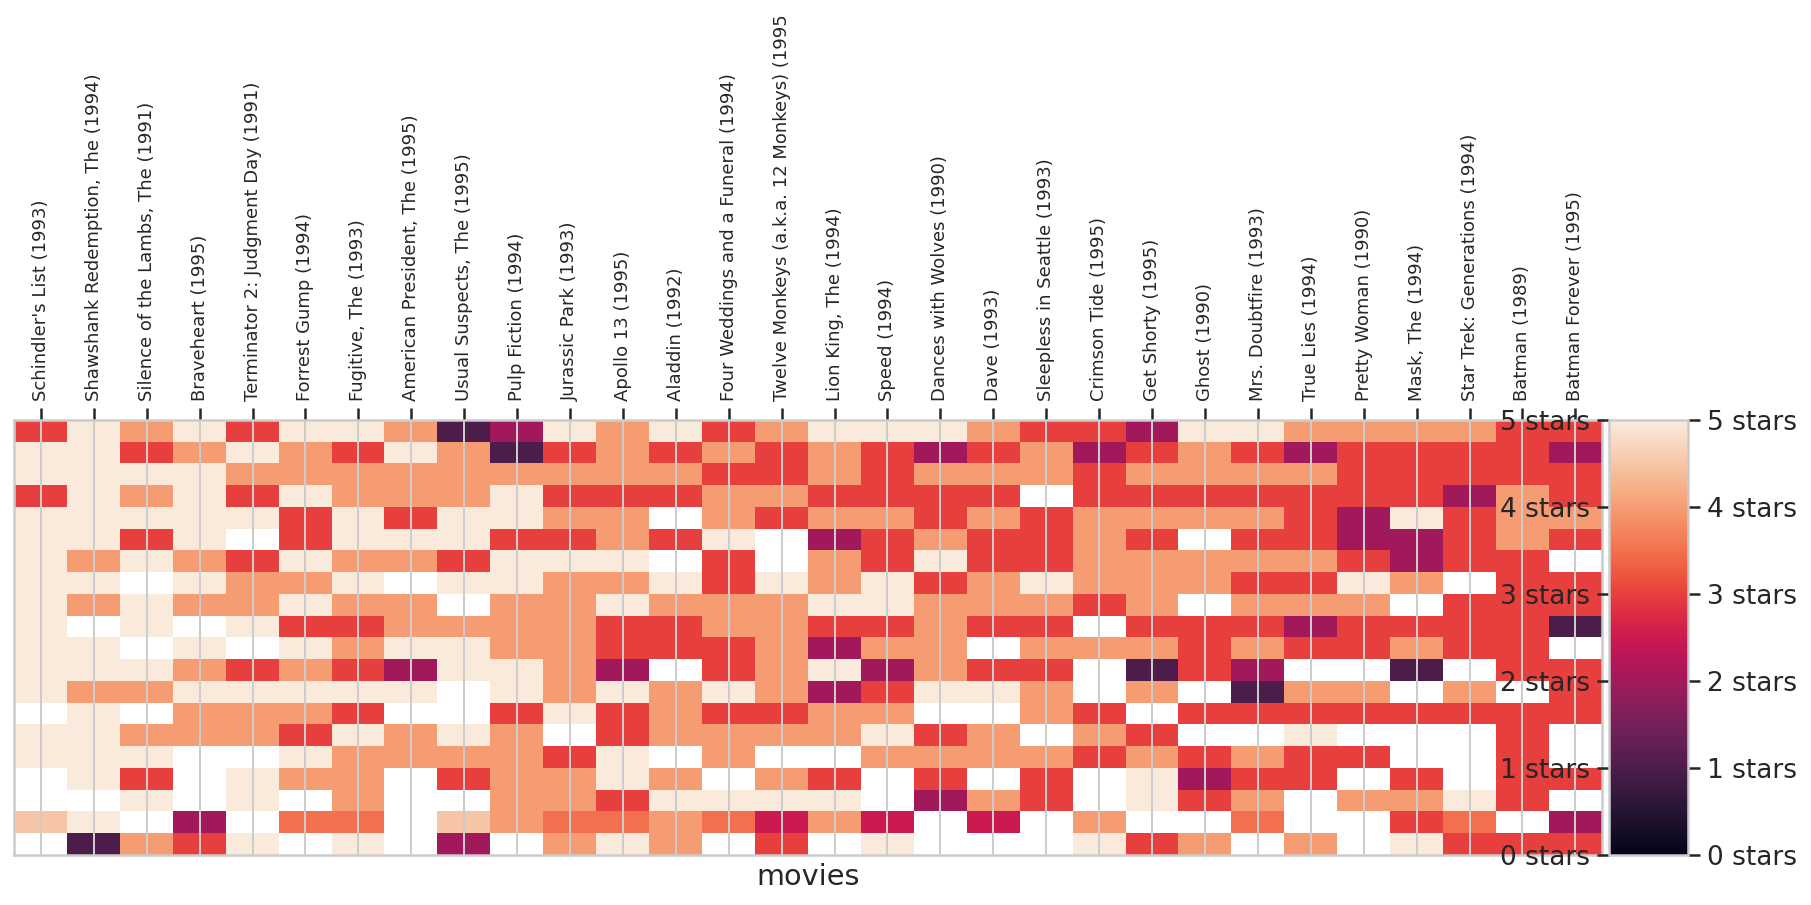

cluster # 0
# of users in cluster: 106. # of users in plot: 20


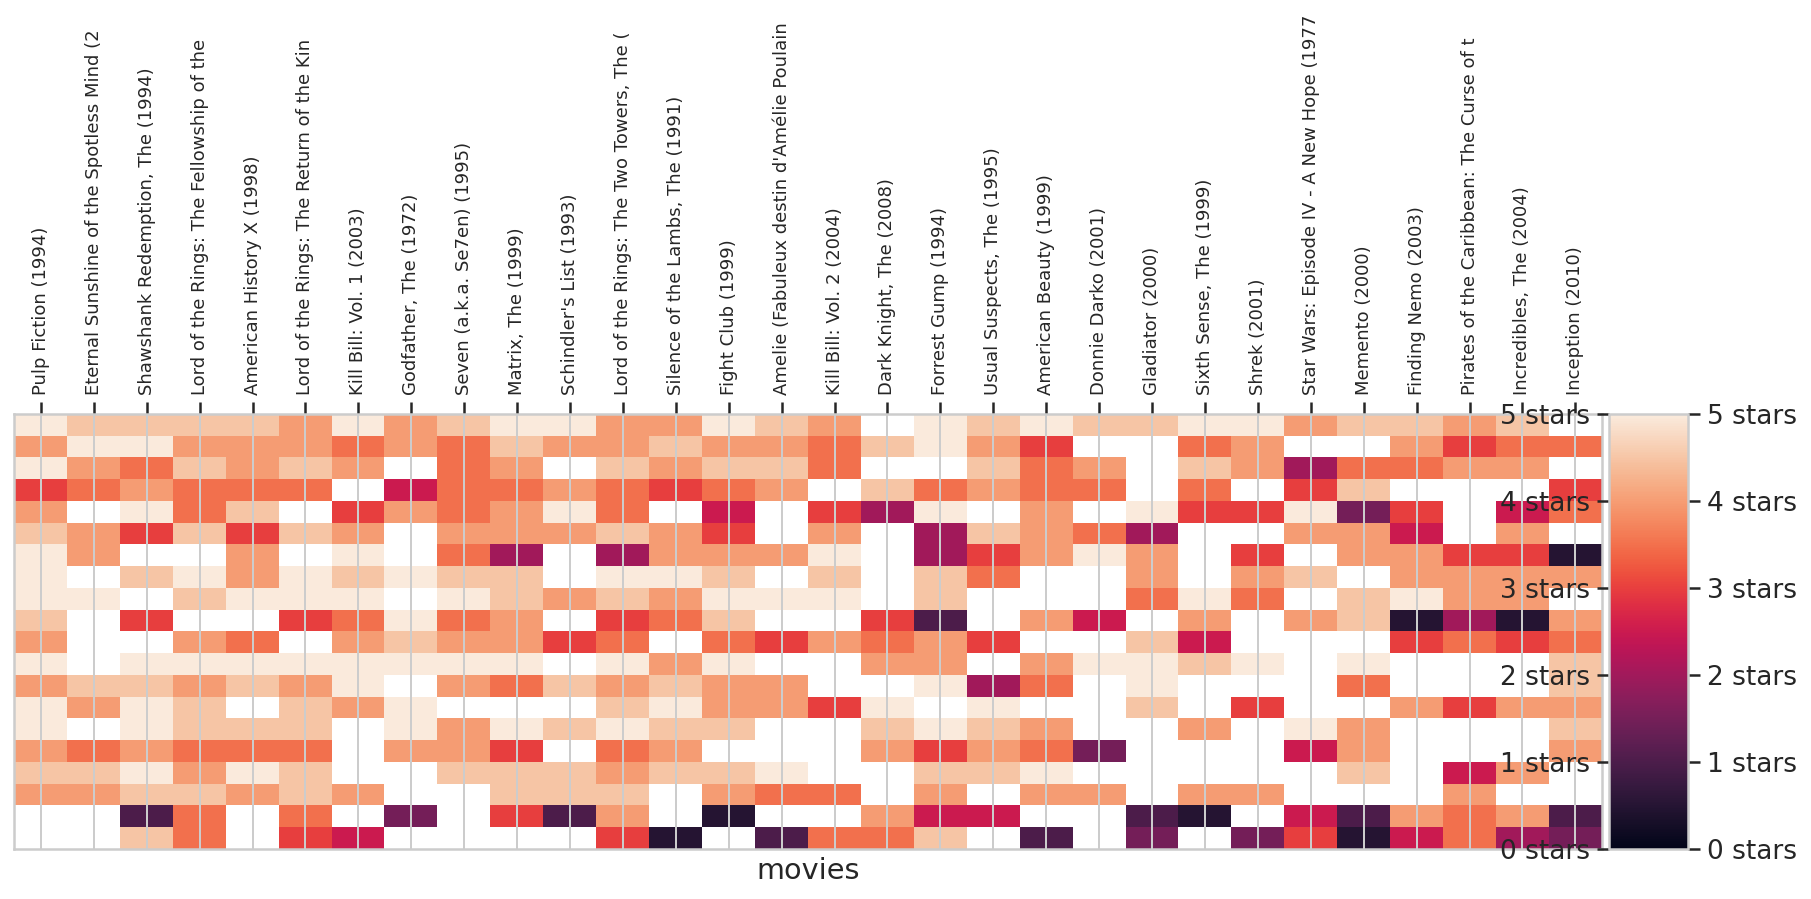

cluster # 1
# of users in cluster: 17. # of users in plot: 17


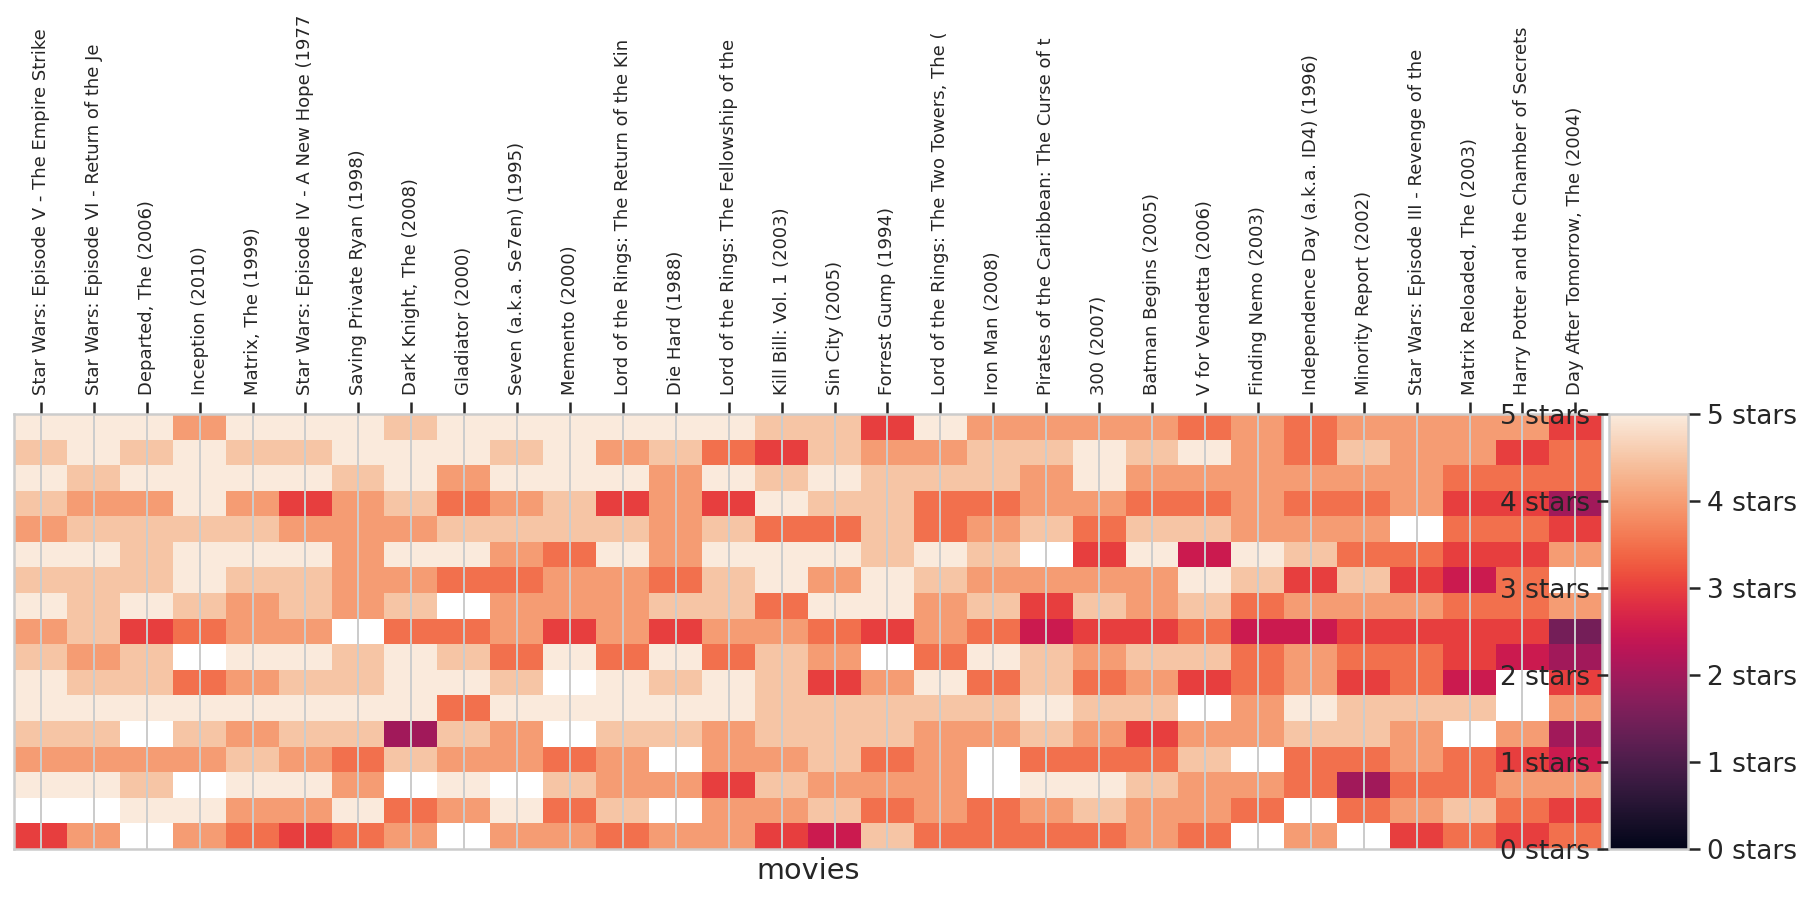

cluster # 3
# of users in cluster: 27. # of users in plot: 20


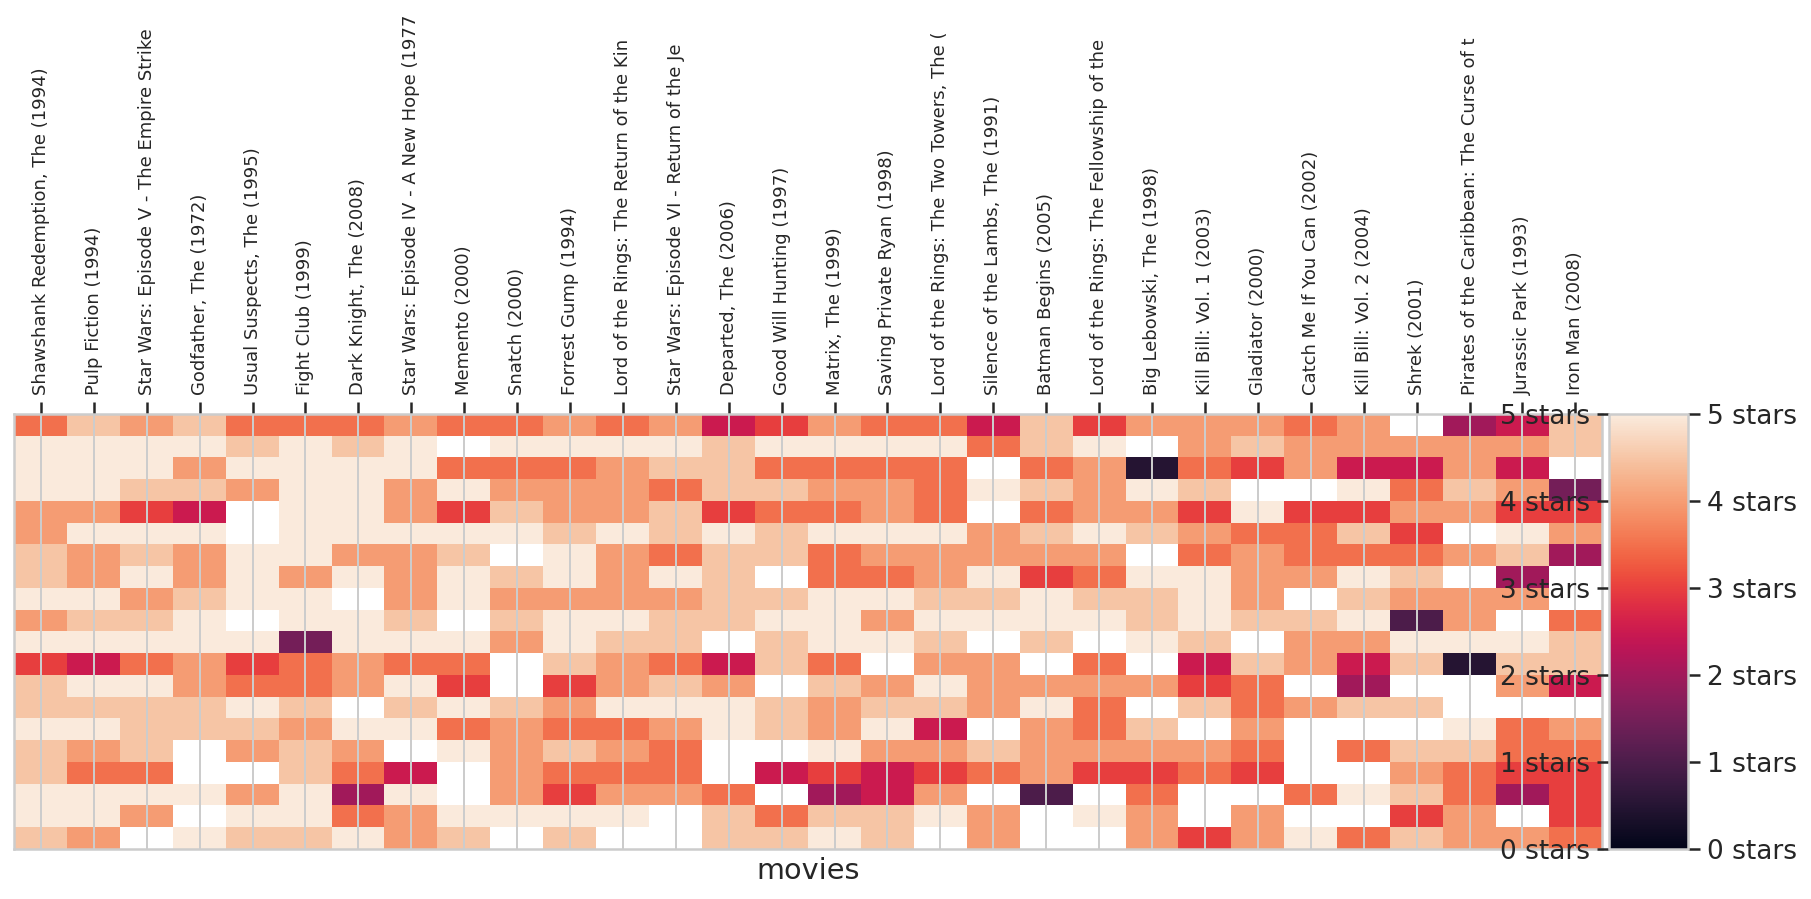

cluster # 4
# of users in cluster: 27. # of users in plot: 20


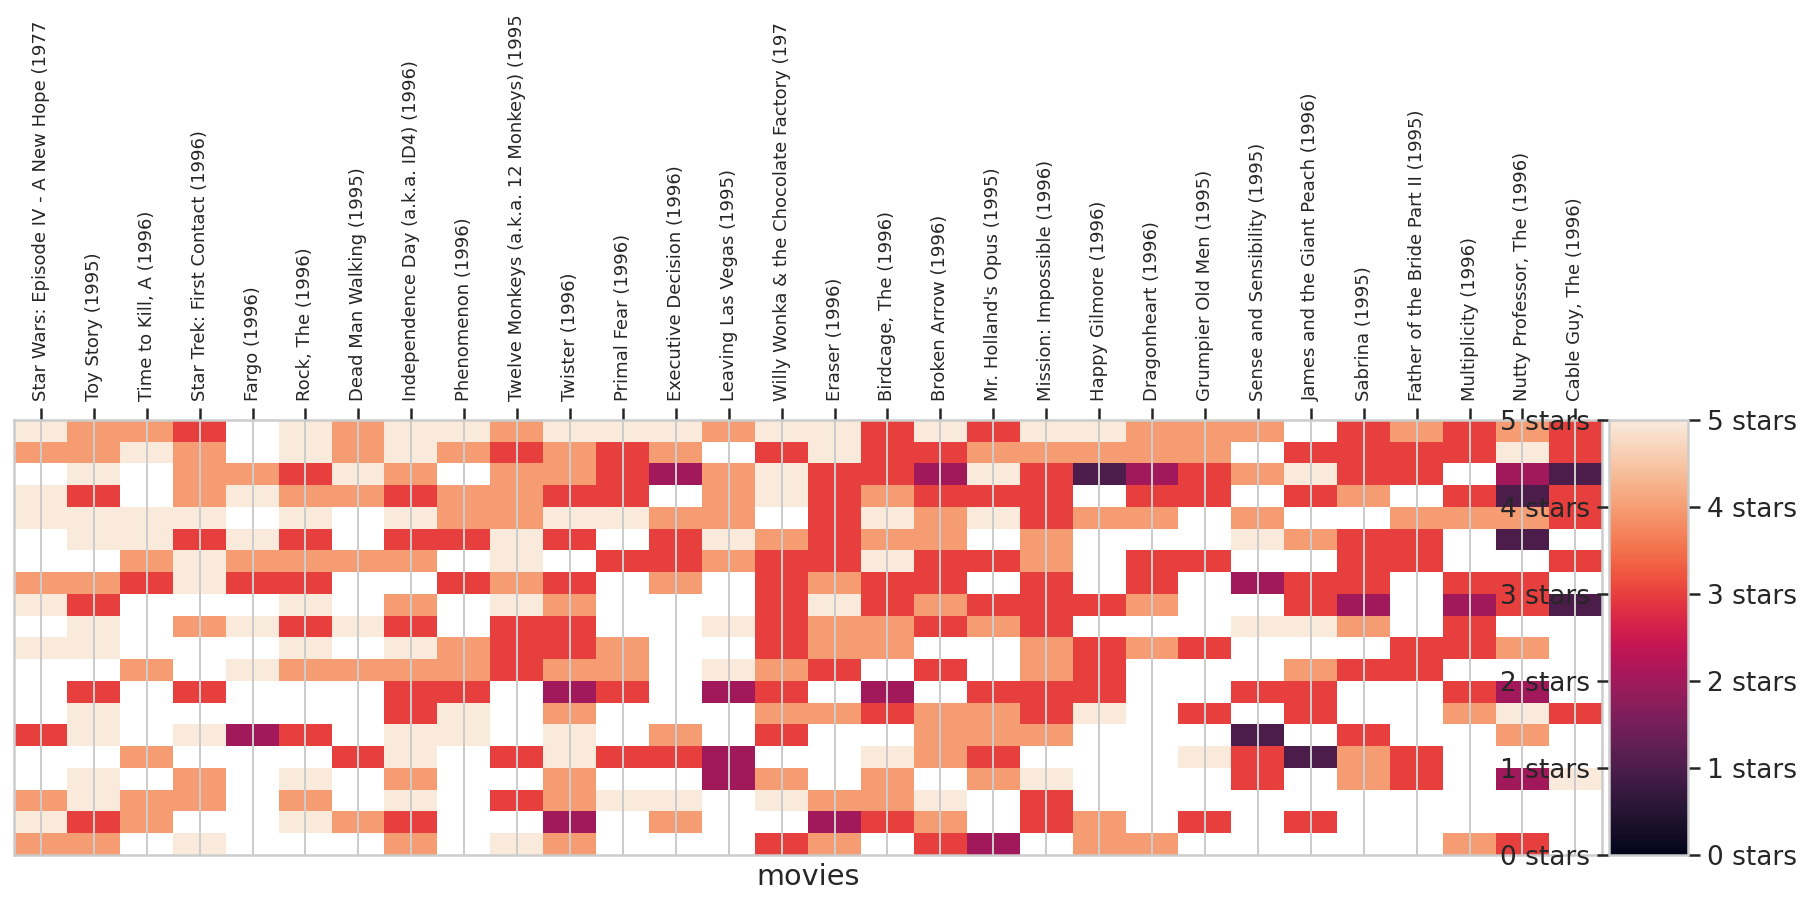

cluster # 2
# of users in cluster: 11. # of users in plot: 11


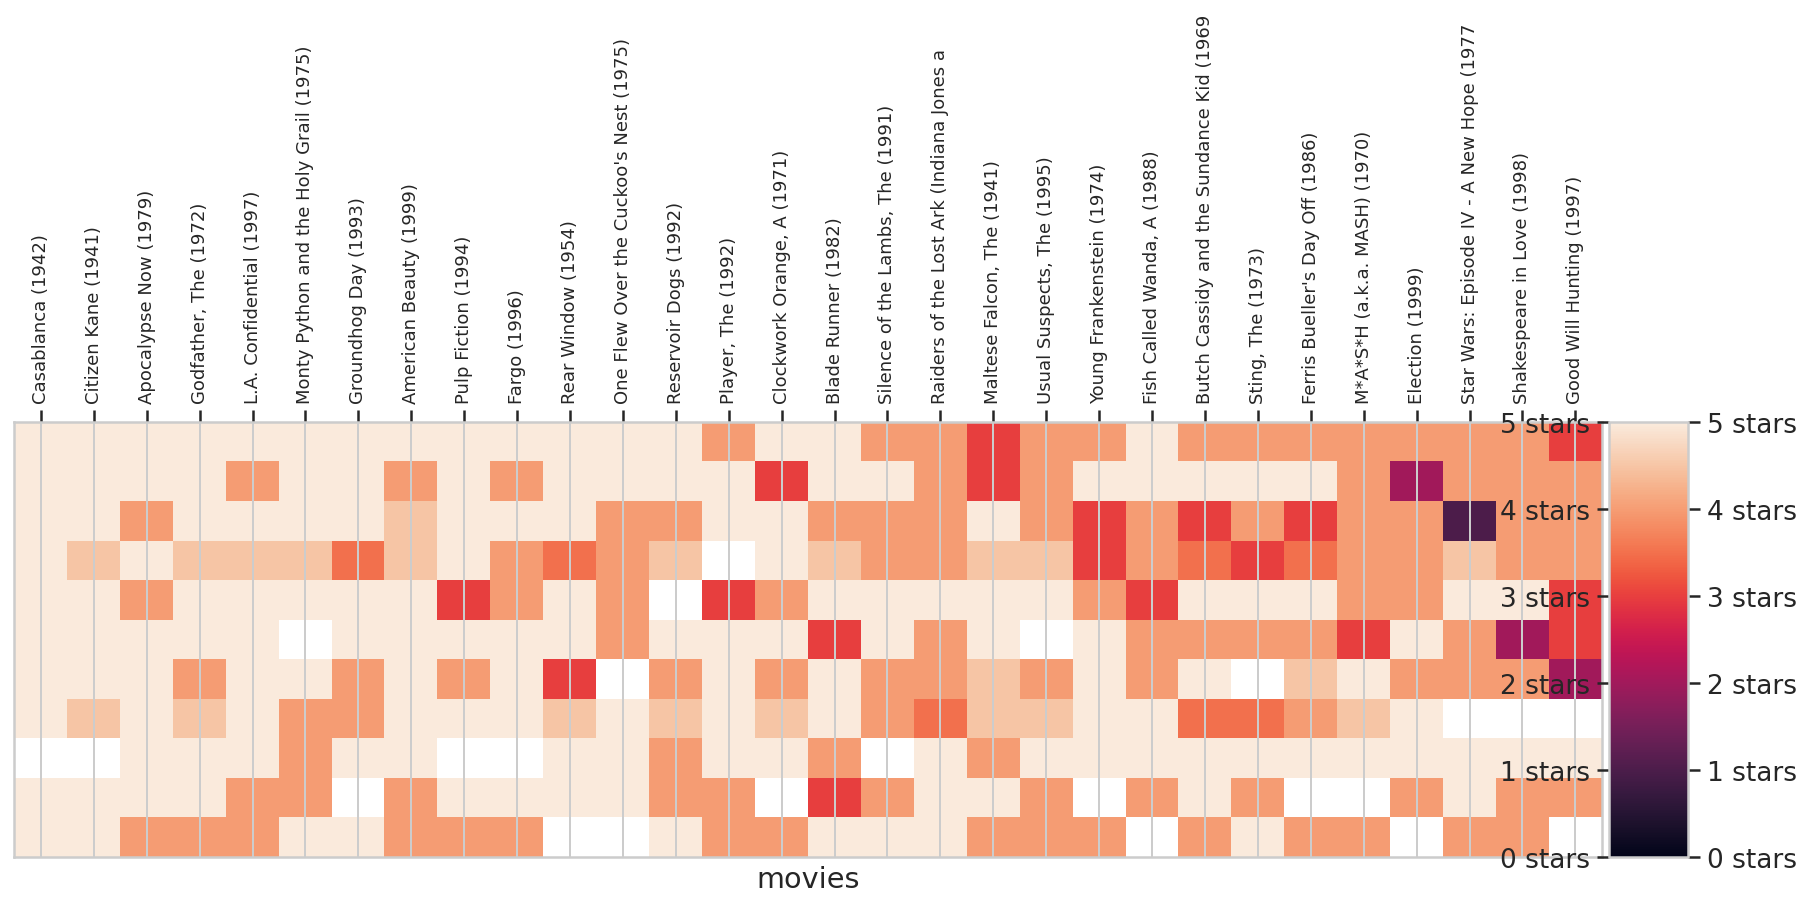

cluster # 12
# of users in cluster: 11. # of users in plot: 11


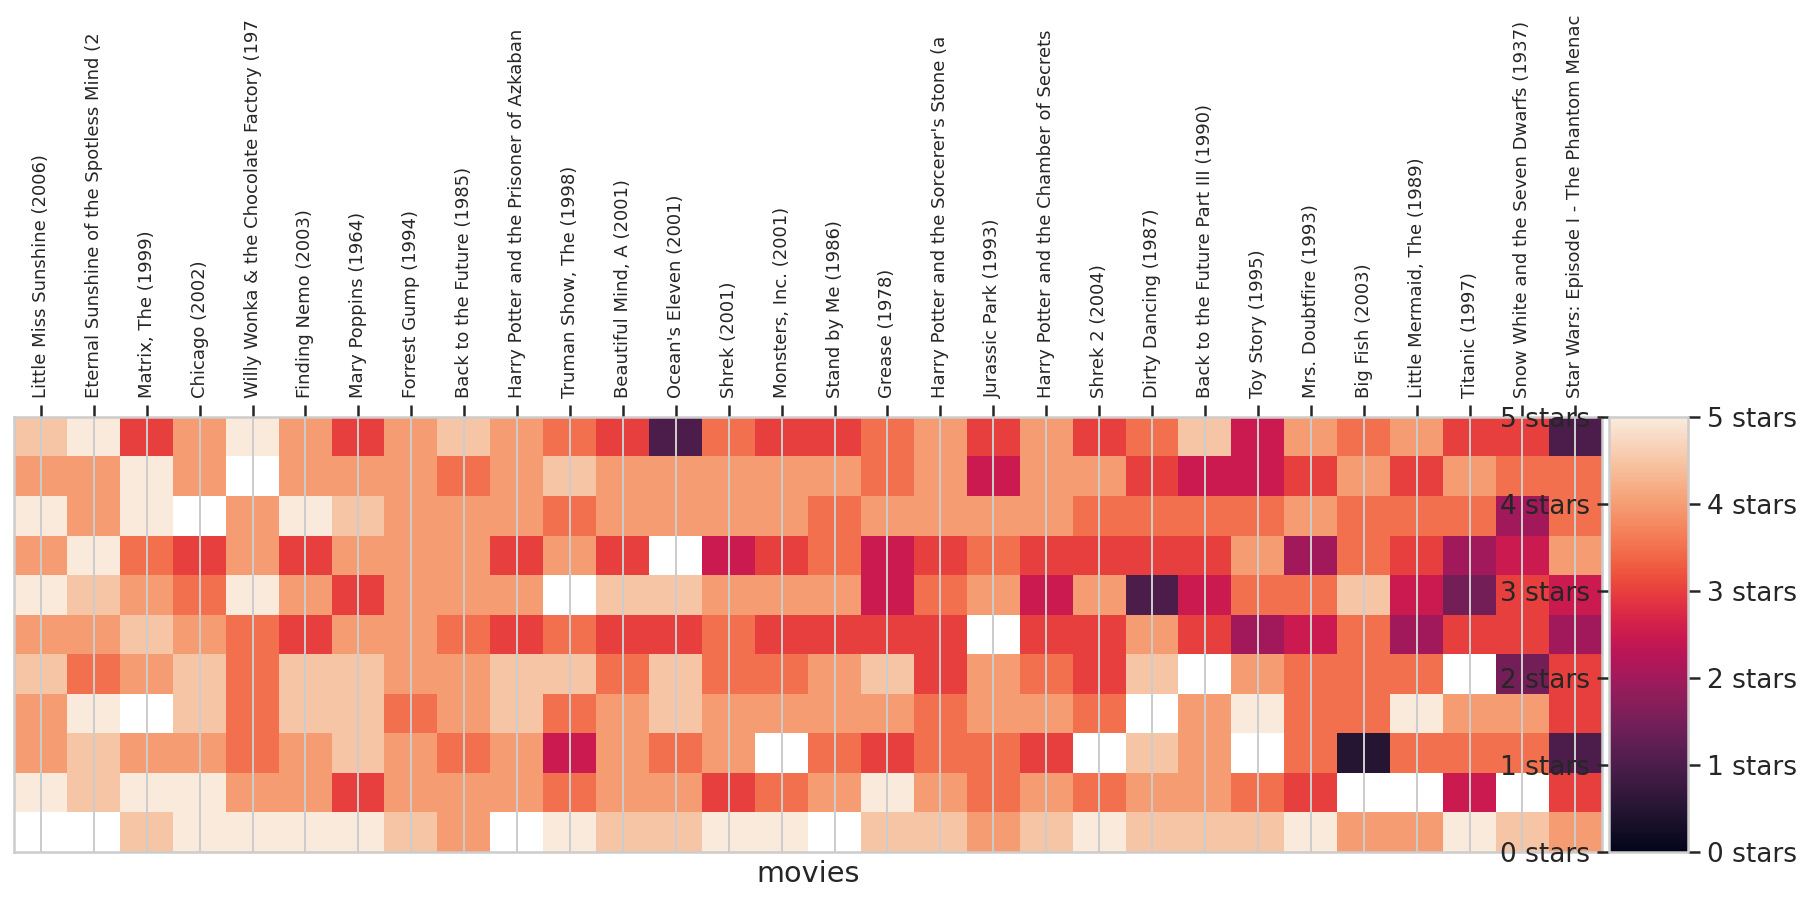

In [66]:
# Select the mas number of users and movies heatmap cluster
max_users = 20
max_movies = 30
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

### Take a closer look to a specific cluster

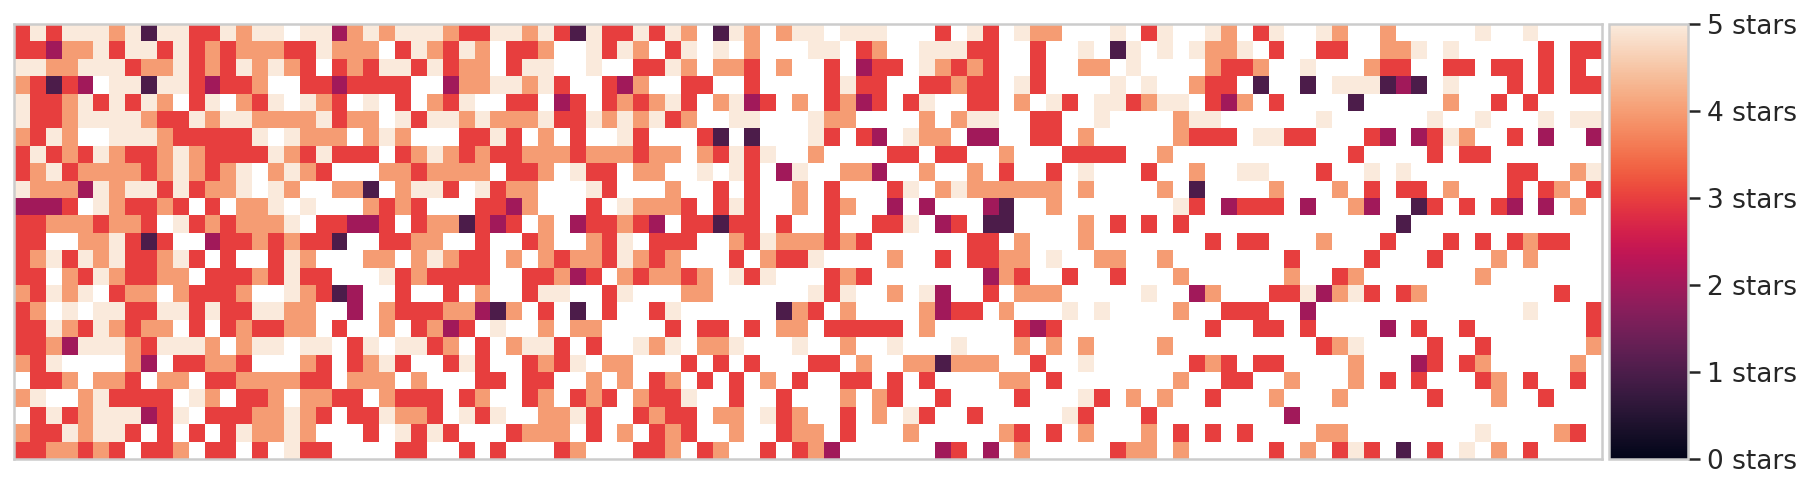

In [69]:
# Pick cluster id
cluster_number = 6
# take a subset of the users with 100 dimensions
n_users = 25
n_movies = 100
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
# Sort and print the cluster
cluster = sort_rating(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [70]:
cluster.fillna('not rated').head()

,Batman (1989),True Lies (1994),Pulp Fiction (1994),Dances with Wolves (1990),Apollo 13 (1995),Forrest Gump (1994),"Fugitive, The (1993)",Die Hard: With a Vengeance (1995),Ace Ventura: Pet Detective (1994),Clear and Present Danger (1994),Braveheart (1995),Batman Forever (1995),Stargate (1994),Cliffhanger (1993),Aladdin (1992),Crimson Tide (1995),Jurassic Park (1993),"Shawshank Redemption, The (1994)","Firm, The (1993)",Outbreak (1995),Dumb & Dumber (Dumb and Dumber) (1994),Waterworld (1995),"Net, The (1995)","Silence of the Lambs, The (1991)",Beauty and the Beast (1991),Speed (1994),Terminator 2: Judgment Day (1991),Star Trek: Generations (1994),Interview with the Vampire: The Vampire Chronicles (1994),"Mask, The (1994)",Seven (a.k.a. Se7en) (1995),GoldenEye (1995),While You Were Sleeping (1995),"Lion King, The (1994)",Quiz Show (1994),Natural Born Killers (1994),Mrs. Doubtfire (1993),Addams Family Values (1993),Babe (1995),Disclosure (1994),...,Demolition Man (1993),Coneheads (1993),Four Weddings and a Funeral (1994),Dave (1993),Judge Dredd (1995),French Kiss (1995),"Usual Suspects, The (1995)",Jumanji (1995),Mission: Impossible (1996),Nell (1994),Independence Day (a.k.a. ID4) (1996),What's Eating Gilbert Grape (1993),Twister (1996),"American President, The (1995)",First Knight (1995),Casper (1995),Species (1995),Maverick (1994),Léon: The Professional (a.k.a. The Professional) (Léon) (1994),Nine Months (1995),"Piano, The (1993)",Desperado (1995),Pocahontas (1995),I.Q. (1994),Mr. Holland's Opus (1995),"Crow, The (1994)",Under Siege 2: Dark Territory (1995),Mortal Kombat (1995),Johnny Mnemonic (1995),Father of the Bride Part II (1995),Tommy Boy (1995),Heat (1995),Little Women (1994),"Birdcage, The (1996)",Bad Boys (1995),Philadelphia (1993),"Flintstones, The (1994)","River Wild, The (1994)",Miracle on 34th Street (1994),"Three Musketeers, The (1993)"
68,3,5.0,3,5,5,5,4,5,1,5,5,3,3,5,4,5,5,not rated,5,5,2,4,5,4,5,5,5,4,3,3,5,5,4,5,3,1,5,3,3,5,...,5,3,not rated,5,4,4,not rated,not rated,not rated,5,not rated,3,5,not rated,not rated,5,4,not rated,3,5,not rated,not rated,5,4,not rated,not rated,4,not rated,not rated,not rated,not rated,not rated,5,not rated,not rated,5,not rated,not rated,not rated,not rated
32,3,3.0,2,4,4,5,3,5,5,3,5,3,4,3,4,4,4,3,3,5,4,4,4,not rated,3,5,4,3,5,4,not rated,3,3,4,not rated,not rated,5,3,5,4,...,3,3,not rated,not rated,3,not rated,not rated,5,not rated,1,5,not rated,5,not rated,5,4,4,5,not rated,3,not rated,not rated,3,3,not rated,not rated,4,4,5,not rated,5,not rated,not rated,not rated,not rated,not rated,3,not rated,3,3
71,5,5.0,4,4,5,5,5,3,4,4,5,3,4,3,5,4,5,4,3,not rated,3,4,3,5,5,3,5,3,4,4,not rated,3,5,5,not rated,not rated,5,not rated,not rated,3,...,4,3,not rated,not rated,3,not rated,not rated,4,4,not rated,5,not rated,not rated,not rated,not rated,4,3,3,4,not rated,not rated,5,not rated,not rated,not rated,4,3,3,not rated,not rated,3,3,not rated,3,3,not rated,3,not rated,3,not rated
21,4,3.0,1,3,2,not rated,5,5,1,5,5,3,2,3,3,4,not rated,not rated,3,3,2,3,3,3,3,not rated,not rated,2,4,4,5,5,4,5,3,not rated,not rated,3,2,4,...,3,3,not rated,5,3,not rated,not rated,not rated,not rated,5,not rated,5,not rated,not rated,4,3,3,not rated,1,not rated,not rated,1,not rated,5,5,5,1,2,1,not rated,5,not rated,not rated,not rated,3,not rated,3,not rated,3,3
26,5,3.0,3,4,5,3,5,3,5,4,not rated,3,5,not rated,4,3,5,not rated,5,4,3,not rated,5,not rated,3,not rated,4,3,5,not rated,not rated,3,3,not rated,2,3,not rated,3,4,3,...,3,3,not rated,4,not rated,5,3,not rated,5,5,3,4,5,5,not rated,3,2,4,not rated,3,not rated,not rated,not rated,not rated,1,not rated,not rated,not rated,not rated,not rated,4,not rated,not rated,3,not rated,3,not rated,not rated,not rated,not rated


In [60]:
# The average rating of 20 highest rated movies by the users in the cluster
cluster.mean().sort_values(ascending=False)[:20]


Top Gun (1986)                                                     5.000000
Wallace & Gromit: The Best of Aardman Animation (1996)             5.000000
Army of Darkness (1993)                                            5.000000
Titanic (1997)                                                     5.000000
Trainspotting (1996)                                               5.000000
Wallace & Gromit: A Close Shave (1995)                             5.000000
Contact (1997)                                                     5.000000
City of Lost Children, The (Cité des enfants perdus, La) (1995)    5.000000
Postman, The (Postino, Il) (1994)                                  5.000000
As Good as It Gets (1997)                                          5.000000
Last of the Mohicans, The (1992)                                   5.000000
Saving Private Ryan (1998)                                         5.000000
Space Jam (1996)                                                   5.000000
Star Trek: F

### Take a random user and recemmend high-rated movies from this cluster which this user have not rated 

In [62]:
# TODO: Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 21

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Star Trek: First Contact (1996)                                    5.000000
Titanic (1997)                                                     5.000000
Army of Darkness (1993)                                            5.000000
Trainspotting (1996)                                               5.000000
Top Gun (1986)                                                     5.000000
Wallace & Gromit: A Close Shave (1995)                             5.000000
Contact (1997)                                                     5.000000
City of Lost Children, The (Cité des enfants perdus, La) (1995)    5.000000
Postman, The (Postino, Il) (1994)                                  5.000000
Wallace & Gromit: The Best of Aardman Animation (1996)             5.000000
Last of the Mohicans, The (1992)                                   5.000000
Saving Private Ryan (1998)                                         5.000000
Space Jam (1996)                                                   5.000000
Hunchback of